# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.

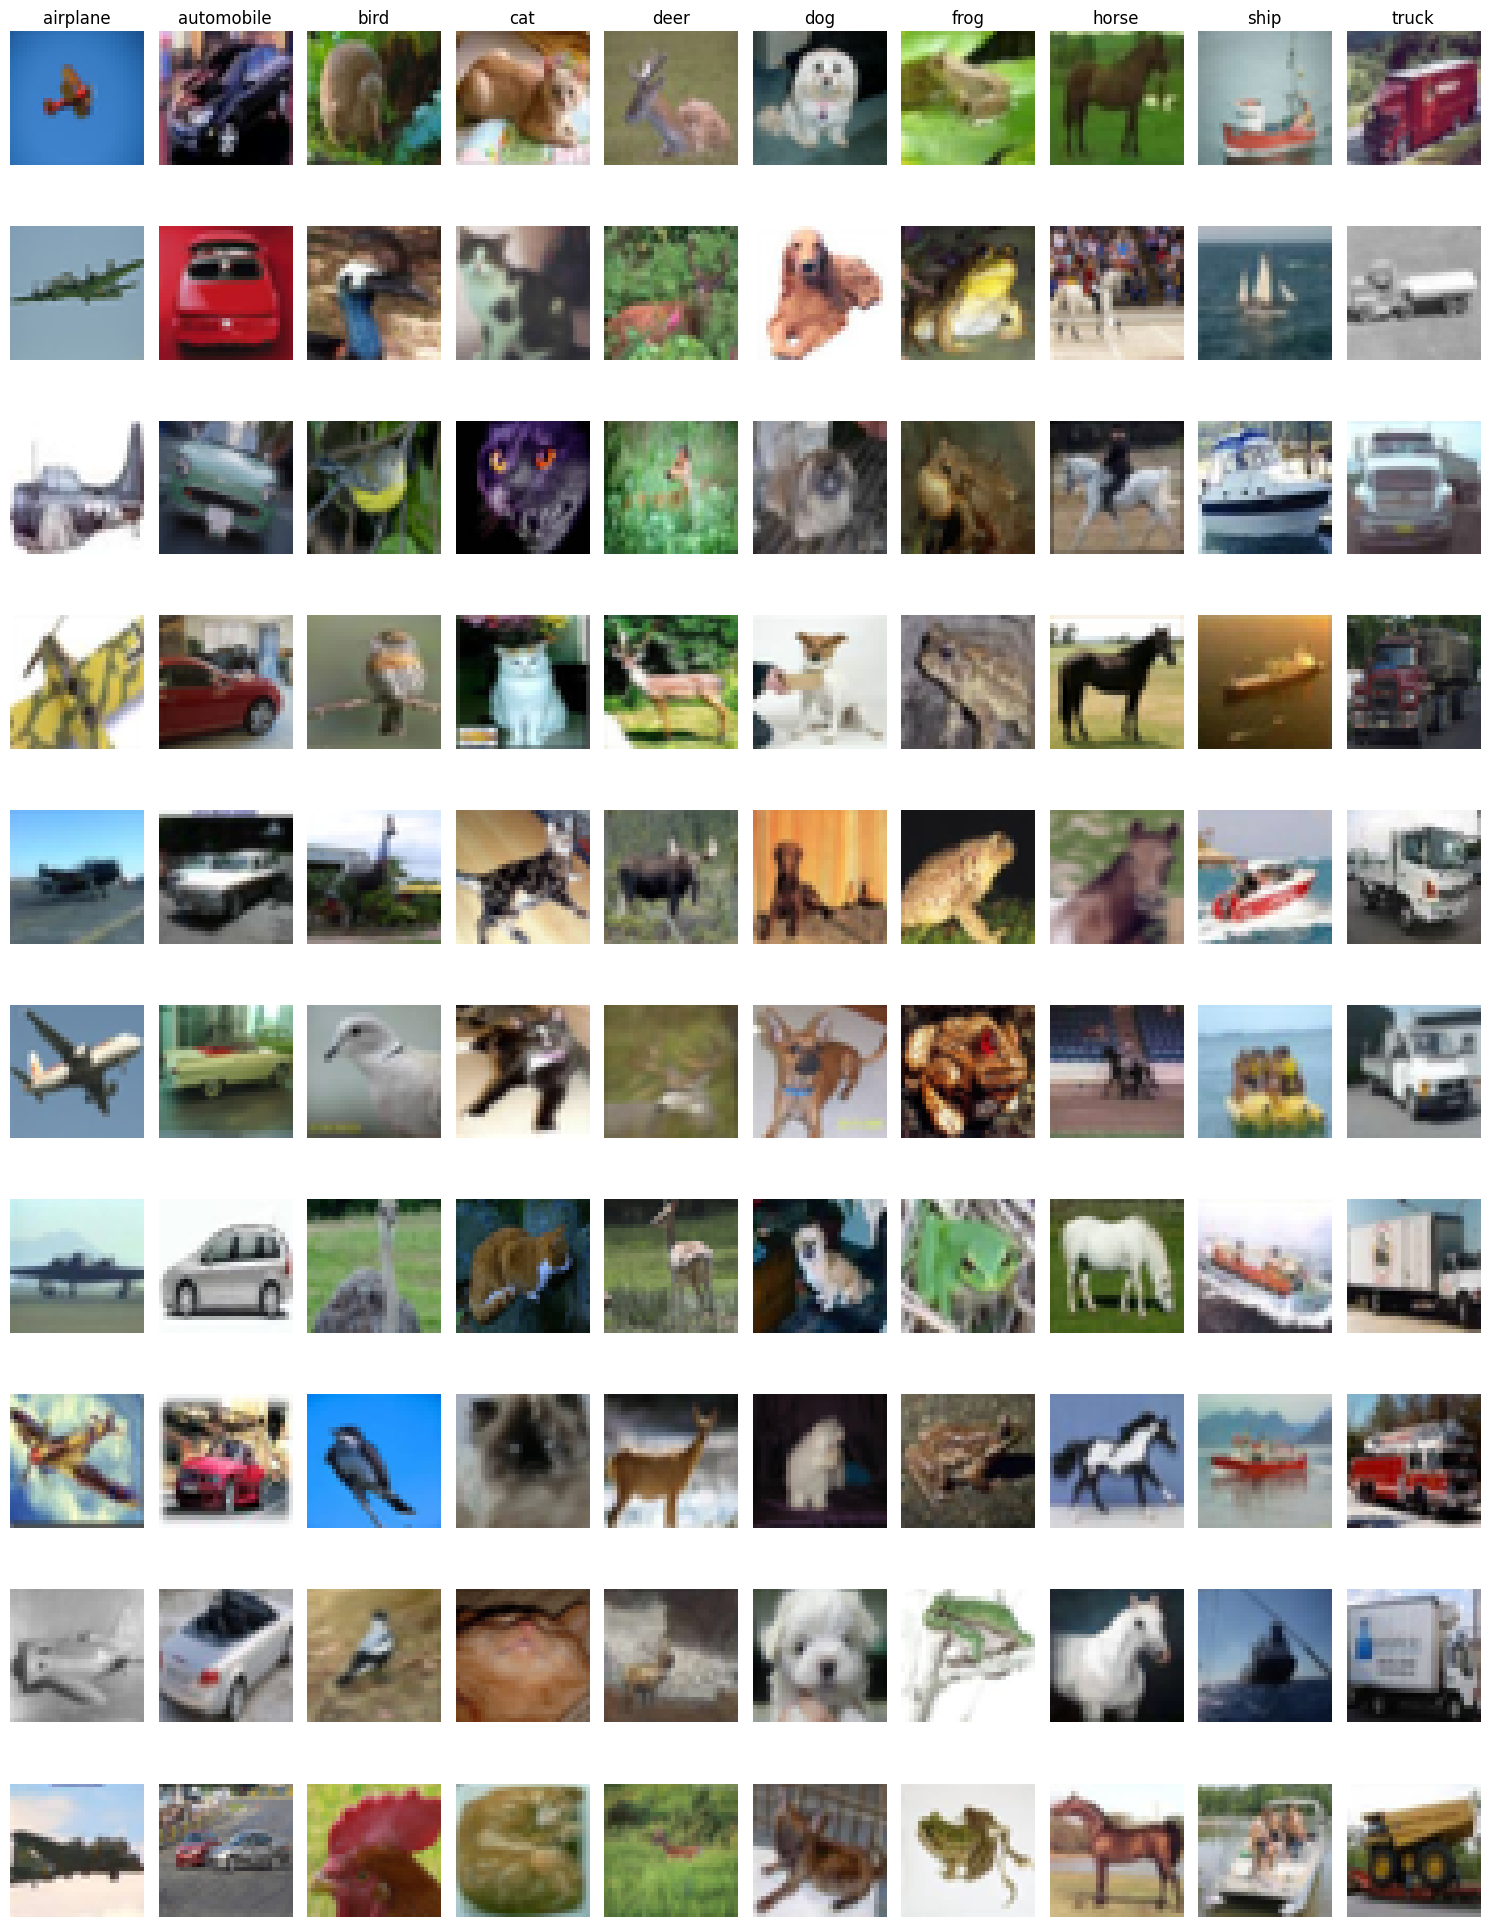

In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = 10
samples_per_class = len(classes)

fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 20))
for y_class in range(num_classes):
    idxs = np.where(y_train == y_class)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        axes[i, y_class].imshow(X_train[idx].astype('uint8'))
        axes[i, y_class].axis('off')

        if i == 0:
            axes[i, y_class].set_title(classes[y_class])

plt.tight_layout()
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [4]:
X_train, y_train = X_train.reshape(X_train.shape[0], -1)[:5000], y_train[:5000]

X_test, y_test = X_test.reshape(X_test.shape[0], -1)[:500], y_test[:500]

1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [5]:
from scripts.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [6]:
y_preds_knn = classifier.predict(X_test, k=5, num_loops=0)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


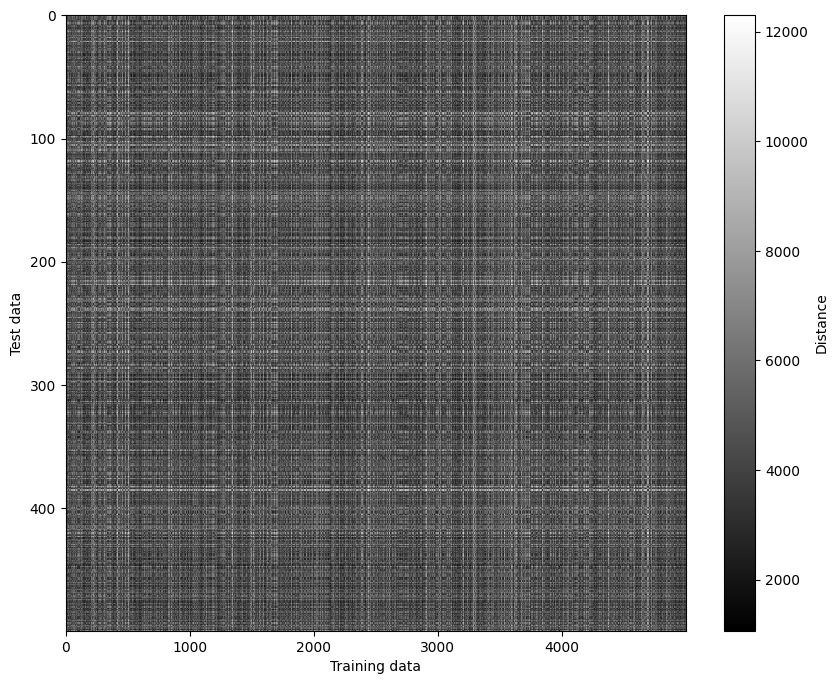

In [7]:
dists = classifier.compute_distances_no_loops(X_test)

plt.imshow(dists, interpolation='none', aspect='auto')
plt.colorbar(label='Distance')
plt.xlabel('Training data')
plt.ylabel('Test data')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [8]:
accuracy_knn = np.mean(y_preds_knn == y_test)

print(f"Accuracy: {accuracy_knn:.3f}")

Accuracy: 0.278


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [9]:
k_values = [2, 3, 4, 5, 7, 9, 10, 15, 20, 25, 30, 40, 50, 75, 100]

knn_accuracy_dict = {}

for k in k_values:
    knn_classifier = KNearestNeighbor()
    knn_classifier.train(X_train, y_train)
    preds = knn_classifier.predict(X_test, k=k, num_loops=0)
    knn_accuracy_dict[k] = np.mean(preds == y_test)

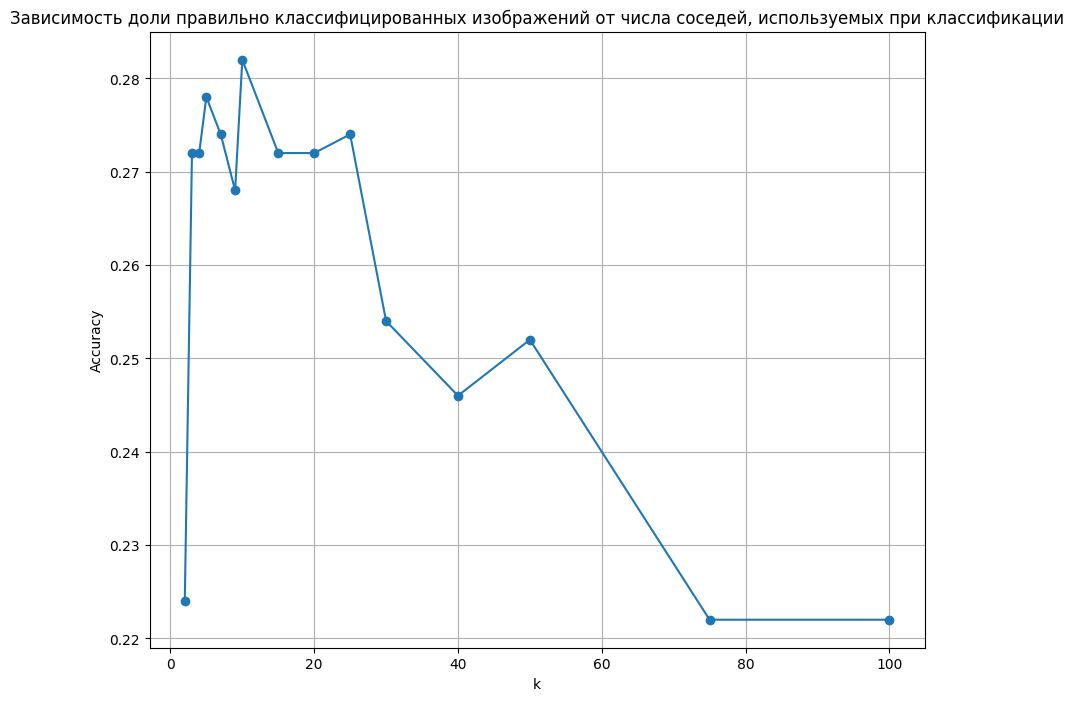

In [10]:
plt.title("Зависимость доли правильно классифицированных изображений от числа соседей, используемых при классификации")
plt.plot(knn_accuracy_dict.keys(), knn_accuracy_dict.values(), marker='o')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [11]:
from tqdm.notebook import tqdm

num_folds = 5

num_training = X_train.shape[0]
indices = np.arange(num_training)
np.random.shuffle(indices)

fold_size = num_training // num_folds
folds = []
for i in range(num_folds):
    start_idx = i * fold_size
    end_idx = start_idx + fold_size if i < num_folds - 1 else num_training
    folds.append(indices[start_idx:end_idx])

cv_results = {k: [] for k in k_values}

for k in tqdm(k_values):
    for fold_idx in range(num_folds):
        val_indices = folds[fold_idx]
        train_indices = np.concatenate([folds[i] for i in range(num_folds) if i != fold_idx])
        
        X_train_fold = X_train[train_indices]
        y_train_fold = y_train[train_indices]
        X_val_fold = X_train[val_indices]
        y_val_fold = y_train[val_indices]
        
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        y_val_pred = classifier.predict(X_val_fold, k=k, num_loops=0)
        
        accuracy = np.mean(y_val_pred == y_val_fold)
        cv_results[k].append(accuracy)

mean_accuracies = {k: np.mean(cv_results[k]) for k in k_values}

  0%|          | 0/15 [00:00<?, ?it/s]

Best k: 7, CV accuracy: 0.2830


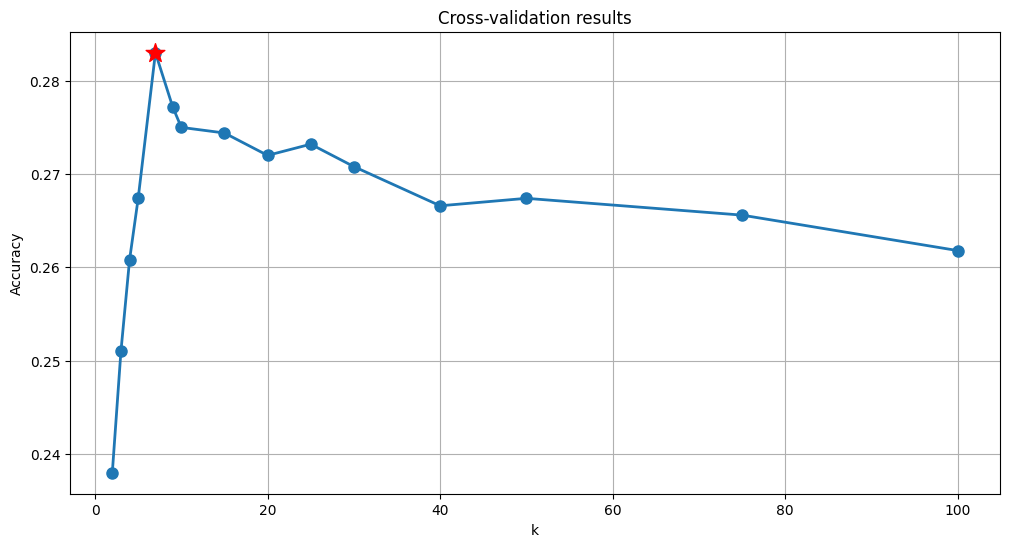

In [12]:
best_k = max(mean_accuracies, key=mean_accuracies.get)

print(f"Best k: {best_k}, CV accuracy: {mean_accuracies[best_k]:.4f}")

means = [mean_accuracies[k] for k in k_values]

plt.figure(figsize=(12, 6))
plt.plot(k_values, means, marker='o', linewidth=2, markersize=8)
plt.scatter([best_k], [mean_accuracies[best_k]], color='red', s=200, marker='*', zorder=5)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Cross-validation results')
plt.grid(True)
plt.show()


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [13]:
final_classifier = KNearestNeighbor()
final_classifier.train(X_train, y_train)
y_test_pred = final_classifier.predict(X_test, k=best_k, num_loops=0)
test_accuracy = np.mean(y_test_pred == y_test)

print(f"Test accuracy with k={best_k}: {test_accuracy:.4f}")

Test accuracy with k=7: 0.2740


1.11 Сделайте выводы по результатам 1 части задания.

На k = 5 получили accuracy = 0.278.

При кросс валидации на 5 фолдах на разных значениях k видно, что наилучшим значением является k=7 (максимум accuracy на кросс валидации от k)

Тем не менее, метрики на тесте даже немного снизилась, что говорит о важности использовании кросс валидации для получения наилучшей модели, так как результаты на тесте могут быть нерепрезентативными и плохо показывать обобщаю способность модели.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [14]:
from sklearn.model_selection import train_test_split


X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Validate data shape: ', X_val.shape)
print('Validate labels shape: ', y_val.shape)

Training data shape:  (45000, 3072)
Training labels shape:  (45000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Validate data shape:  (5000, 3072)
Validate labels shape:  (5000,)


2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

[130.8046     136.21415556 132.71115556 130.24088889 135.59737778
 132.00917778 131.13768889 136.38624444 132.71897778 131.63717778]


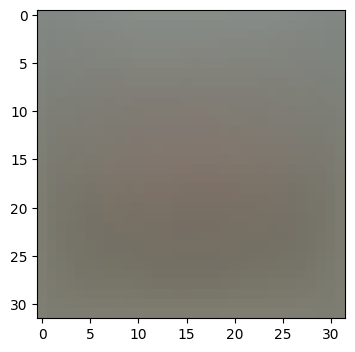

(45000, 3073) (5000, 3073) (10000, 3073)


In [15]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [16]:
num_dev = 500
mask = np.random.choice(X_train.shape[0], num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [17]:
from scripts.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
import time


W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.808472



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [18]:

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -3.346292 analytic: -3.346292, relative error: 3.872568e-11
numerical: 33.655877 analytic: 33.655877, relative error: 2.199659e-12
numerical: -12.384395 analytic: -12.384395, relative error: 1.442577e-11
numerical: -23.050923 analytic: -22.937754, relative error: 2.460810e-03
numerical: -15.082918 analytic: -15.082918, relative error: 3.092948e-12
numerical: -3.428344 analytic: -3.428344, relative error: 2.389538e-11
numerical: -2.952175 analytic: -2.952175, relative error: 2.152945e-11
numerical: 16.198660 analytic: 16.195999, relative error: 8.215862e-05
numerical: 12.016222 analytic: 12.016222, relative error: 2.216569e-11
numerical: -9.176037 analytic: -9.176037, relative error: 4.914967e-11
numerical: -20.221635 analytic: -20.221635, relative error: 1.562224e-11
numerical: 15.011599 analytic: 15.011599, relative error: 2.768342e-11
numerical: -10.629746 analytic: -10.701023, relative error: 3.341524e-03
numerical: 0.642045 analytic: 0.642045, relative error: 2.874791e-1

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [19]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.036981s
Vectorized loss and gradient: computed in 0.001131s
difference: 0.000000


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [20]:
from scripts.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 790.956683
iteration 100 / 1500: loss 287.331877
iteration 200 / 1500: loss 107.929850
iteration 300 / 1500: loss 43.266080
iteration 400 / 1500: loss 19.280636
iteration 500 / 1500: loss 9.993626
iteration 600 / 1500: loss 6.764075
iteration 700 / 1500: loss 5.915542
iteration 800 / 1500: loss 6.134593
iteration 900 / 1500: loss 5.182850
iteration 1000 / 1500: loss 5.348816
iteration 1100 / 1500: loss 5.055421
iteration 1200 / 1500: loss 5.489666
iteration 1300 / 1500: loss 5.184385
iteration 1400 / 1500: loss 5.245305
That took 1.670825s


In [21]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.372578
validation accuracy: 0.357800


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [22]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

In [23]:
from sklearn.model_selection import KFold
import pandas as pd
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for lr in learning_rates:
    for reg in regularization_strengths:
        fold_acc = []
        for train_idx, val_idx in kfold.split(X_trainval):
            svm = LinearSVM()
            svm.train(
                X_trainval[train_idx], y_trainval[train_idx],
                learning_rate=lr, reg=reg,
                num_iters=1500, batch_size=200, verbose=False
            )
            preds = svm.predict(X_trainval[val_idx])
            fold_acc.append(np.mean(preds == y_trainval[val_idx]))

        results.append({
            "lr": lr,
            "reg": reg,
            "cv_acc": np.mean(fold_acc)
        })
        print(f"lr={lr:.1e}, reg={reg:.1e} -> acc={np.mean(fold_acc):.4f}")

results_df = pd.DataFrame(results).sort_values("cv_acc", ascending=False)
display(results_df)
best = results_df.iloc[0]
print(f"\nЛучшие параметры: lr={best.lr:.1e}, reg={best.reg:.1e}, cv_acc={best.cv_acc:.4f}")

lr=1.0e-07, reg=2.5e+04 -> acc=0.3635
lr=1.0e-07, reg=5.0e+04 -> acc=0.3511
lr=5.0e-05, reg=2.5e+04 -> acc=0.0630
lr=5.0e-05, reg=5.0e+04 -> acc=0.1000


,lr,reg,cv_acc
0,1.000000e-07,25000.0,0.36348
1,1.000000e-07,50000.0,0.35114
3,5.000000e-05,50000.0,0.10000
2,5.000000e-05,25000.0,0.06296



Лучшие параметры: lr=1.0e-07, reg=2.5e+04, cv_acc=0.3635


In [24]:
best_svm = LinearSVM()
best_svm.train(
    X_train, y_train,
    learning_rate=best.lr,
    reg=best.reg,
    num_iters=1500,
    batch_size=200,
    verbose=True
)

y_val_pred = best_svm.predict(X_val)
val_acc = np.mean(y_val_pred == y_val)
print(f"Validation accuracy: {val_acc:.4f}")

y_test_pred = best_svm.predict(X_test)
test_acc = np.mean(y_test_pred == y_test)
print(f"Test accuracy: {test_acc:.4f}")

iteration 0 / 1500: loss 796.975484
iteration 100 / 1500: loss 289.492256
iteration 200 / 1500: loss 108.951895
iteration 300 / 1500: loss 42.656762
iteration 400 / 1500: loss 18.396193
iteration 500 / 1500: loss 10.032751
iteration 600 / 1500: loss 7.103814
iteration 700 / 1500: loss 5.733440
iteration 800 / 1500: loss 5.034064
iteration 900 / 1500: loss 5.917541
iteration 1000 / 1500: loss 5.225820
iteration 1100 / 1500: loss 5.591806
iteration 1200 / 1500: loss 5.972426
iteration 1300 / 1500: loss 5.616880
iteration 1400 / 1500: loss 5.119424
Validation accuracy: 0.3584
Test accuracy: 0.3680


2.9 Сделайте выводы по второй части задания

Лучшие параметры: lr=1.0e-07, reg=2.5e+04, cv_acc=0.3635

При повышении learning rate до 5e-5 происходит значительное снижение качества модели. Гиперпараметр "reg" такого явного влияния не показывает, однако меньшее значение показывает бОльшую целевую метрику 